#In this program we will use LSTM to predict the agriculture product price in Cambodia

In [1]:
#import lib
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import json
from datetime import datetime
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
#get price list
filepath = "data/greenpaper_price.json"
with open(filepath, 'r') as file:
  content = file.read()

json_content = json.loads(content)
dates = [datetime.strptime(json_content[0]['prices'][index]['date'][0:10], "%Y-%m-%d").date() for index in range(0, len(json_content[0]['prices']))]
# dates = [json_content[0]['prices'][index]['date'][0:10] for index in range(0, len(json_content[0]['prices']))]
prices = [float(json_content[0]['prices'][index]['price']) for index in range(0, len(json_content[0]['prices']))]

df = pd.DataFrame(data=prices, index=dates, columns=['Prices'], dtype=None, copy=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


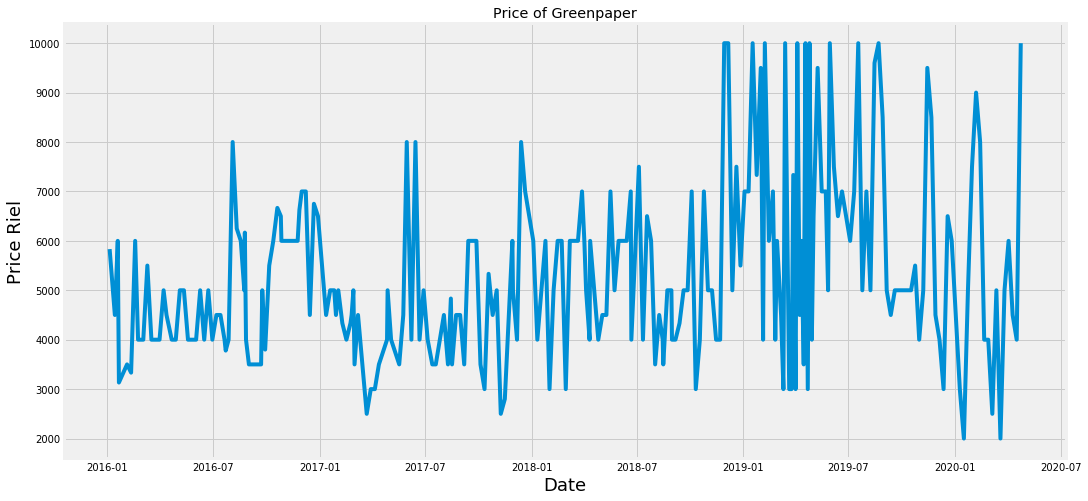

In [3]:
#vitualization
plt.figure(figsize=(16, 8))
plt.title('Price of Greenpaper')
plt.plot(df['Prices'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price Riel', fontsize=18)
plt.show()

In [4]:
#create new dataframe with only the prices column
data = df.filter(['Prices'])
#conver the dataframe to a numpy array
dataset = data.values
#get the number of rows to train model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

194

In [5]:
#scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#split the data into x_train and y_train dataset
x_train, y_train = [], []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i])
  y_train.append(train_data[i, 0])

In [7]:
#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(134, 60, 1)

In [9]:
#build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
134/134 [==============================] - 4s 30ms/step - loss: 0.0618


In [12]:
#create the testing dataset
#create new array containing scaled value from 143 to 203
test_data = scaled_data[training_data_len - 60: , :]
#create dataset x_test and y_test
x_test, y_test = [], dataset[training_data_len: , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [13]:
#convert the data to numpy array
x_test = np.array(x_test)

In [14]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
#get the root mean square error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

2199.4385196406333

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


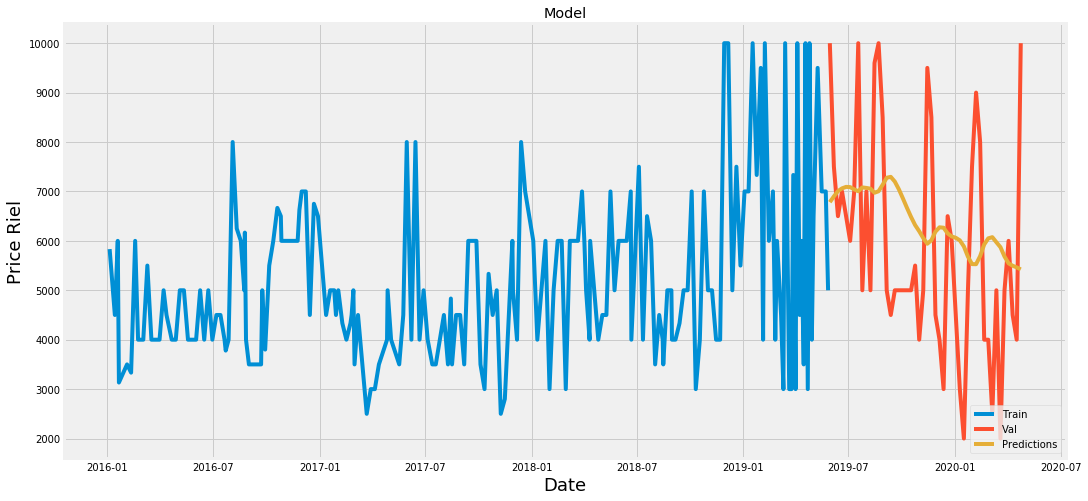

In [17]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#vitualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price Riel', fontsize=18)
plt.plot(train['Prices'])
plt.plot(valid[['Prices', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()